In [ ]:
!gdown --id 1-3c1uHL_uiqToeX4Pq90ijidBw1aDp9I

In [ ]:
!unzip dataset_mask.zip

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms 
import torchvision 
import torch.nn as nn
from sklearn.model_selection import train_test_split
import cv2
import os

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataloader


In [5]:
class MaskDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.list_images_path = []
    self.list_labels = []
    self.one_hot_label = {"nomask": 0, "mask": 1}
    for sub_dir in os.listdir(root_dir):
      path_sub_dir = os.path.join(root_dir, sub_dir)
      for image_name in os.listdir(path_sub_dir):
        image_path = os.path.join(path_sub_dir, image_name)
        label = sub_dir
        self.list_images_path.append(image_path)
        self.list_labels.append(label)
    
    self.transform = transform
  
  def __len__(self):
    return len(self.list_images_path)
  
  def __getitem__(self, idx):
    image = cv2.imread(self.list_images_path[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (384, 384))
    image = image.astype('float')
    label = np.array(self.one_hot_label[self.list_labels[idx]]).astype('float')

    sample = (image, label)
    if self.transform:
      sample = self.transform(sample)
    
    return sample # image, label

In [6]:
class convertToTensor:
  def __call__(self, sample):
    image, label = sample

    # opencv image: H x W x C
    # torch tensor: C x H x W
    image = torch.from_numpy(image).permute(2, 0, 1).float()
    label = torch.from_numpy(label).long()

    return (image, label)

In [7]:
transformed_train_data = MaskDataset('dataset_mask/train', transform=transforms.Compose([convertToTensor()]))
transformed_test_data = MaskDataset('dataset_mask/val', transform=transforms.Compose([convertToTensor()]))

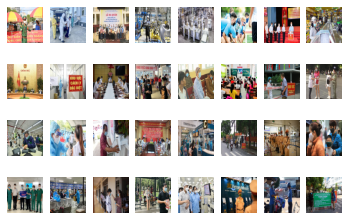

In [8]:
col = 8
row = 4

fig = plt.figure()
for index in range(1, col*row + 1):
  plt.subplot(row, col, index)
  plt.axis('off')
  plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(transformed_train_data.list_images_path[index]), cv2.COLOR_BGR2RGB), (224, 224)))

In [9]:
train_data_loader = DataLoader(transformed_train_data, batch_size=16, shuffle=True)
test_data_loader = DataLoader(transformed_test_data, batch_size=16, shuffle=True)

# VIT

In [10]:
class PatchEmbed(nn.Module):
  def __init__(self, image_size, patch_size, in_channels=3, embed_dims=768):
    super().__init__()
    self.image_size = image_size
    self.patch_size = patch_size 
    self.n_patches = (image_size // patch_size) ** 2

    # convolutional layer that does both the splitting into patches and their embedding 
    self.cv2D_layer = nn.Conv2d(in_channels, embed_dims, kernel_size=patch_size, stride=patch_size)
  
  def forward(self, x):
    '''
      input: X tensor - Shape: (n_samples, in_chans, image_size, image_size).
      output: tensor - Shape: (n_samples, n_patches, embed_dim)
    '''
    x = self.cv2D_layer(x) # Shape: (n_samples, embed_dims, patch_size // 2, patch_size // 2)
    x = x.flatten(2) # Shape: (n_samples, embed_dims, n_patches)
    x = x.transpose(1, 2) # Shape: (n_samples, n_patches, embed_dims)

    return x

In [11]:
class Attention(nn.Module):
  def __init__(self, dim, n_heads=12, qkv_bias=True, drop_attn_ratio=0., drop_ratio=0.):
    super().__init__()
    self.n_heads = n_heads 
    self.dim = dim
    self.head_dim = dim // n_heads
    self.scale = self.head_dim ** -0.5 
    
    self.qkv = nn.Linear(dim, dim*3, bias=qkv_bias)
    self.attn_drop = nn.Dropout(drop_attn_ratio)
    self.fc = nn.Linear(dim, dim)
    self.fc_drop = nn.Dropout(drop_ratio)
  
  def forward(self, x):
    '''
      input: Shape: (n_samples, n_patches + 1, dim)
      output: (n_samples, n_patches + 1, dim)
    '''
    n_samples, n_token, dim = x.shape 
    if dim != self.dim:
      raise ValueError 
    
    qkv = self.qkv(x) # shape: (n_samples, n_patches+1, dim*3)
    qkv = qkv.reshape(n_samples, n_token, 3, self.n_heads, self.head_dim) # shape: (n_samples, n_patches + 1, 3, n_heads, head_dim)
    qkv = qkv.permute(2, 0, 3, 1, 4) # shape (3, n_samples, n_heads, n_patches+1, head_dim)
    q, k, v = qkv[0], qkv[1], qkv[2]
    k_t = k.transpose(-2, -1)  # shape: (n_samples, n_heads, head_dim, n_patches + 1)
    dot_product = (q @ k_t) * self.scale # shape: (n_samples, n_heads, n_patches + 1, n_patches + 1)
    attn = dot_product.softmax(dim=-1)  # shape: (n_samples, n_heads, n_patches + 1, n_patches + 1)
    attn = self.attn_drop(attn)
    weighted_avg = attn @ v  # shape: (n_samples, n_heads, n_patches +1, head_dim)
    weighted_avg = weighted_avg.transpose(1, 2)  # shape: (n_samples, n_patches + 1, n_heads, head_dim)
    weighted_avg = weighted_avg.flatten(2)  # shape: (n_samples, n_patches + 1, dim)
    x = self.fc(weighted_avg)
    x = self.fc_drop(x) 

    return x 

In [12]:
class MLP(nn.Module):
  def __init__(self, in_features, hidden_features, out_features, drop_ratio=0.):
    super().__init__()
    self.fc1 = nn.Linear(in_features, hidden_features)
    self.activation_func = nn.GELU()
    self.fc2 = nn.Linear(hidden_features, out_features)
    self.dropout = nn.Dropout(drop_ratio)
  
  def forward(self, x):
    x = self.fc1(x)
    x = self.activation_func(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.dropout(x)

    return x 

In [13]:
class TransformerBlock(nn.Module):
  def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, dropout_attn_ratio=0., dropout_ratio=0.):
    super().__init__()
    self.norm1 = nn.LayerNorm(dim, eps=1e-6)
    self.attn = Attention(dim, n_heads=n_heads, qkv_bias=qkv_bias, drop_attn_ratio=dropout_attn_ratio, drop_ratio=dropout_ratio)
    self.norm2 = nn.LayerNorm(dim, eps=1e-6)
    hidden_features = int(dim * mlp_ratio)
    self.mlp = MLP(in_features=dim, hidden_features=hidden_features, out_features=dim)
  
  def forward(self, x):
    x = x + self.attn(self.norm1(x))
    x = x + self.mlp(self.norm2(x))

    return x

In [14]:
class VisionTransformer(nn.Module):
  def __init__(self, n_classes=2, image_size=384, patch_size=16, in_channels=3, embed_dims=768, depth=12, \
               n_heads=12, mlp_ratio=4., qkv_bias=True, dropout_attn_ratio=0., dropout_ratio=0.):
    super().__init__()
    self.patch_embed = PatchEmbed(image_size=image_size, patch_size=patch_size, in_channels=in_channels, embed_dims=embed_dims)
    self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dims))
    self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dims))
    self.pos_drop = nn.Dropout(dropout_ratio)
    self.blocks = nn.ModuleList(
      [
          TransformerBlock(
            dim = embed_dims,
            n_heads = n_heads,
            mlp_ratio = mlp_ratio,
            qkv_bias = qkv_bias,
            dropout_attn_ratio = dropout_attn_ratio, 
            dropout_ratio = dropout_ratio
          )
          for _ in range(depth)
      ]
    )
    self.norm = nn.LayerNorm(embed_dims, eps=1e-6)
    self.head = nn.Linear(embed_dims, n_classes)
  
  def forward(self, x):
    n_samples = x.shape[0]
    x = self.patch_embed(x)
    cls_token = self.cls_token.expand(n_samples, -1, -1)
    x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1 + n_patches, embed_dims)
    x = x + self.pos_embed  
    x = self.pos_drop(x)
    for block in self.blocks:
      x = block(x)
    x = self.norm(x)
    cls_token_final = x[:, 0] 
    x = self.head(cls_token_final)

    return x

In [15]:
model = VisionTransformer(2).to(device)

In [16]:
optimizer = torch.optim.SGD(model.parameters(), lr=3e-4)
loss_function = nn.CrossEntropyLoss()

# Train

In [17]:
'''
    Function for computing the accuracy of the predictions over the entire data_loader
'''
def get_accuracy(model, data_loader, device):
    correct = 0
    total = 0
    
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100*(correct/total)

'''
    Function for plotting training and validation losses
'''
def plot_losses(train_acc, valid_acc):
    # change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(train_acc, color="blue", label="Train_acc")
    ax.plot(valid_acc, color="red", label="Validation_acc")
    ax.set(title="Acc over epochs",
            xlabel="Epoch",
            ylabel="Acc")
    ax.legend()
    fig.show()

  # change the plot style to default
    plt.style.use('default')

'''
    function for the training step of the training loop
'''
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader)

    return model, optimizer, epoch_loss 

'''
    function for the validation step of the training loop
'''
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass and record loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(valid_loader)

    return model, epoch_loss

'''
    function defining the entire training loop
'''
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    # set object for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    list_train_acc = []
    list_val_acc = []

    valid_loss_min = np.Inf
    # train model
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)

        if epoch % print_every == print_every - 1:
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)


            print('Epochs: {}, Train_loss: {}, Valid_loss: {}, Train_accuracy: {}, Valid_accuracy: {}'.format(
                    epoch, train_loss, valid_loss, train_acc, valid_acc
                    ))

            list_train_acc.append(train_acc)
            list_val_acc.append(valid_acc)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

        if valid_loss < valid_loss_min:
            torch.save(model, 'model.pt')
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss

    plot_losses(list_train_acc, list_val_acc)

    return model, optimizer, (train_losses, valid_losses)

Epochs: 0, Train_loss: 0.6294548313868673, Valid_loss: 0.6858133971691132, Train_accuracy: 59.78905735003296, Valid_accuracy: 59.907834101382484
Validation loss decreased (inf --> 0.685813).  Saving model ...
Epochs: 1, Train_loss: 0.6331880318491082, Valid_loss: 0.6214302128979138, Train_accuracy: 69.08371786420567, Valid_accuracy: 68.66359447004609
Validation loss decreased (0.685813 --> 0.621430).  Saving model ...
Epochs: 2, Train_loss: 0.6253160282185203, Valid_loss: 0.6300907049860273, Train_accuracy: 69.01779828609097, Valid_accuracy: 68.89400921658986
Epochs: 3, Train_loss: 0.6275591470693287, Valid_loss: 0.6308826761586326, Train_accuracy: 68.22676334871457, Valid_accuracy: 68.4331797235023
Epochs: 4, Train_loss: 0.6226112052014, Valid_loss: 0.6285113958375794, Train_accuracy: 69.08371786420567, Valid_accuracy: 68.66359447004609


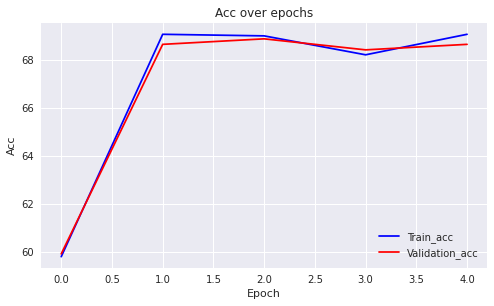

In [18]:
model, optimizer, _ = training_loop(model, loss_function, optimizer, train_data_loader, test_data_loader, 5, device)